In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as md
import matplotlib.patches as mpatches

In [0]:
class Data:
    def __init__ (self,fname):
        self.fname = fname    
        self.df = pd.read_csv(self.fname)
        self.condition_start_end = []
        self.df_score = pd.DataFrame()
        self.base = 0
        self.conds = [self.df['bat2_condition'].unique()]
        self.df_min = None
        self.df_stat = pd.DataFrame()
        self.bats_stat_df = pd.DataFrame(columns=['bat_id','pump_1_reward','pump_1_no_reward',
                                        'pump_2_reward','pump_2_no_reward', 'pump_1_sum', 'pump_2_sum',
                                        'pumps_sum'])
        self.df_filled = pd.DataFrame()
        self.stay_prob_df = pd.DataFrame()
        self.stay_num_df = None
        self.proba_df = None

    def time_to_index(self):
        """change time column into datetime index"""
        self.df.rename(columns={'Unnamed: 0' :'time'}, inplace=True)
        self.df.index = pd.to_datetime(self.df['time'], dayfirst=True)
        self.df.drop(['time'], axis=1, inplace=True)

    def remove_duplicated(self): #not in use
        """remove duplicated timestamps while keeping last value"""
        bool_series = self.df['Unnamed: 0'].duplicated(keep = 'last')
        self.df = self.df[~bool_series] 

    def basic_stat(self): #not finished
        """ return the sum of choices that did each bat into a new df """
        # df_stat = self.df.copy().groupby('feeder').count()
        self.df_stat = self.df.copy().groupby('bat1_condition').count()
        self.df_stat.drop(['signal', 'bat1_id', 'bat1_loc', 'bat2_id',      'bat2_loc', 'bat2_condition'], axis=1, inplace=True)
        print (self.df_stat)

    def bats_stat(self): # not finished
        """ statistics for each bat"""
        # finding all unique tags:
        tags = self.df_filled['bat1_id'].unique().tolist()
        tags.extend(self.df_filled['bat2_id'].unique().tolist())
        tags = list(set(tags))
        tags = [x for x in tags if str(x) != 'nan']
        print (tags)
        for tag in tags:
            tag_count = self.df_filled[self.df_filled['bat1_id']==tag].count(axis=0)
            # print (tag_count)
            if tag_count['bat1_id'] == 0: #checks if tag is in bat1_id, if not than it in bat2_id
                tag_count = self.df_filled[self.df_filled['bat2_id']==tag].count(axis=0)
                reward_count_1 = self.df_filled.groupby(['bat2_id','pump_1'])
                reward_count_2 = self.df_filled.groupby(['bat2_id','pump_2'])
            else:
                reward_count_1 = self.df_filled.groupby(['bat1_id','pump_1'])
                reward_count_2 = self.df_filled.groupby(['bat1_id','pump_2'])
            
            # print (reward_count_1.get_group((tag,'1')).count())
            # print (reward_count_1.get_group((tag,'1')).count()['pump_1'])
            tag_dict = {'bat_id': tag, 
                        'pump_1_reward': reward_count_1.get_group((tag,'1')).count()['pump_1'],
                        'pump_1_no_reward': reward_count_1.get_group((tag,'no 1')).count()['pump_1'],
                        'pump_2_reward': reward_count_2.get_group((tag,'2')).count()['pump_2'], 
                        'pump_2_no_reward': reward_count_2.get_group((tag,'no 2')).count()['pump_2'], 
                        'pump_1_sum': tag_count['pump_1'], 'pump_2_sum': tag_count['pump_2'], 
                        'pumps_sum': (tag_count['pump_1']+tag_count['pump_2'])}
        
            self.bats_stat_df = self.bats_stat_df.append(tag_dict, ignore_index=True)

            # self.bats_stat_df = pd.MultiIndex.from_frame(self.bats_stat_df, names = ['bat_id','pump_1_reward','pump_1_no_reward',
            #                             'pump_2_reward','pump_2_no_reward', 'pump_1_sum', 'pump_2_sum',
            #                             'pumps_sum'])
        print (self.bats_stat_df)
        self.bats_stat_df.to_csv(f"{self.fname}_bats_stat.csv")
        
    def pump_score(self, fill_na = True): 
        """ give score 1 to each right feeder choice, score (-1) to left feeder choice,
        score 0 when no choice been made (only if fillna = True). save this df into a csv file"""
        self.df_score = self.df.copy() 
        mapping_1 = {'no 1': -1, 1: -1}
        mapping_2 = {'no 2': 1, 2: 1}
        self.df_score['pump_1'].fillna(0, inplace= True)
        self.df_score['pump_2'].fillna(0, inplace= True)
        self.df_score =  self.df_score.astype({'pump_1': 'object', 'pump_2': 'object'})
        self.df_score.replace({'pump_1': mapping_1, 'pump_2': mapping_2}, inplace= True)
        self.df_score =  self.df_score.astype({'pump_1': 'int', 'pump_2': 'int'})
        self.df_score['sum_pump'] = self.df_score['pump_1']+self.df_score['pump_2']
        if fill_na == False: # when fill_na=False only results where bat chose will be taken into account
            self.df_score.sum_pump.replace(0, np.nan, inplace=True)
        self.df_score.to_csv(f"{self.fname}_score.csv")

    def match (self):
        """ add a column with y/n if value was as expected or not. later used for plotting"""
        self.df_score = pd.DataFrame(self.df.copy())
        self.df_score['match'] = np.where( 
                                ( (self.df_score['pump_1'] == '1') & (self.df_score['bat2_condition'] == 'L reward' ) ) 
                                | ( (self.df_score['pump_1'] == 'no 1') & (self.df_score['bat2_condition'] == 'R reward' ) )
                                | ( (self.df_score['pump_2'] == '2') & (self.df_score['bat2_condition'] == 'R reward' ))
                                | ( (self.df_score['pump_2'] == 'no 2') & (self.df_score['bat2_condition'] == 'L reward' ))
                                , 's', 'x')

        # print (self.df_score[self.df_score['match'] == 'y'])
        # self.df.rename(columns={'Unnamed: 0' :'time'}, inplace=True)
        self.df_score.to_csv(f"{self.fname}_score.csv")

    def stay_prob (self):
        """ יש לך 4 אפשרויות. כמו באיור. פידר א גמול, א בלי גמול וכו. 
        נגיד שבחלון היו עשרה מקרים של א עם גמול, 
        מה הסיכוי שההחלטה היתה להשאר, כלומר לחזור ל-א"""
        ## prepare df:
        self.stay_prob_df = self.df.copy()
        mapping_1 = {'no 1': -1}
        mapping_2 = {'no 2': -2}
        self.stay_prob_df['pump_1'].fillna(0, inplace= True)
        self.stay_prob_df['pump_2'].fillna(0, inplace= True)
        self.stay_prob_df = self.stay_prob_df.astype({'pump_1': 'object', 'pump_2': 'object'})
        self.stay_prob_df.replace({'pump_1': mapping_1, 'pump_2': mapping_2}, inplace= True)
        self.stay_prob_df = self.stay_prob_df.astype({'pump_1': 'int', 'pump_2': 'int'})
        self.stay_prob_df['sum_pump'] = self.stay_prob_df['pump_1']+self.stay_prob_df['pump_2']
        self.stay_prob_df['sum_pump'].replace(0, np.nan, inplace = True)
        # self.stay_prob_df.sum_pump.replace(0, np.nan, inplace=True)
        self.stay_prob_df.dropna(subset=['sum_pump'],inplace = True)
        self.stay_prob_df['pre_choice'] = self.stay_prob_df['sum_pump'].shift(1)
        self.stay_prob_df['choice'] = self.stay_prob_df['sum_pump']
        map_choice = {-1:1,-2:2}
        self.stay_prob_df.replace({'choice': map_choice}, inplace= True)

    def stay_change_to_df(self,cond): #new version
        """ create stay-change number (for specefic condition) df based on stay_prob func"""
        # df1 = exp.stay_prob_df
        df1= exp.stay_prob_df[exp.stay_prob_df['bat2_condition']== cond].copy()
        # print (df1)
        #create masks for pump_1
        reward_1_stay = (df1['pre_choice']==1) & (df1['choice']==1)
        reward_1_change = (df1['pre_choice']==1) & (df1['choice']==2)
        unreward_1_stay = (df1['pre_choice']==-1) & (df1['choice']==1)
        unreward_1_change = (df1['pre_choice']==-1) & (df1['choice']==2)
        #create masks for pump_2
        reward_2_stay = (df1['pre_choice']==2) & (df1['choice']==2)
        reward_2_change = (df1['pre_choice']==2) & (df1['choice']==1)
        unreward_2_stay = (df1['pre_choice']==-2) & (df1['choice']==2)
        unreward_2_change = (df1['pre_choice']==-2) & (df1['choice']==1)
        #create dict 
        reward = {'stay_1':df1[reward_1_stay].choice.count(), 'change_1':df1[reward_1_change].choice.count(),
                  'stay_2':df1[reward_2_stay].choice.count(), 'change_2':df1[reward_2_change].choice.count()}
        unreward = {'stay_1':df1[unreward_1_stay].choice.count(), 'change_1':df1[unreward_1_change].choice.count(),
                    'stay_2':df1[unreward_2_stay].choice.count(), 'change_2':df1[unreward_2_change].choice.count()}
        proba_dict = {'reward' :reward,'unreward':unreward}
       
        self.stay_num_df = pd.DataFrame(proba_dict)


    def stay_prob_to_df(self):
        """ create stay-change probability df based on..."""
        self.proba_df = self.stay_num_df.copy().T
        # self.proba_df['Probability_1'] = self.proba_df['stay_1']/(self.proba_df['stay_1']+self.proba_df['change_1'])
        # self.proba_df['Probability_2'] = self.proba_df['stay_2']/(self.proba_df['stay_2']+self.proba_df['change_2'])
        self.proba_df['Left_feeder(20)'] = self.proba_df['stay_1']/(self.proba_df['stay_1']+self.proba_df['change_1'])
        self.proba_df['Right_feeder(80)'] = self.proba_df['stay_2']/(self.proba_df['stay_2']+self.proba_df['change_2'])
        self.proba_df.drop(['stay_1','change_1','stay_2','change_2'], axis=1, inplace=True)
  

    def plot_prob(self):
        ax = self.proba_df.plot.bar()
        ax.set_title('Right feeder rewards')
        ax.set_ylabel('Probability')


    def run_prob(self,cond):
        self.stay_prob()
        self.stay_change_to_df(cond)
        self.stay_prob_to_df()
        # self.right_left_df()
        self.plot_prob()

    # def mean_pref(self, min = '10Min'): #not finished
    #     mean_pref = self.df_score.resample(min, self.base, label='right').mean()

    def fill_bat_id_gaps (self, gap_limit = 10):
        """ fills gaps in reading bat_ids, good when there is more than 2 bats
        and we need to know which one activiated the feeder"""
        self.df_filled = self.df.copy()
        self.df_filled['bat1_id'].fillna (method= 'ffill', limit= gap_limit, inplace= True)
        self.df_filled['bat2_id'].fillna (method= 'ffill', limit= gap_limit, inplace= True)
        self.df_filled.to_csv(f'{fname}_fill_gaps.csv')

    def find_base(self):
        self.base = self.df.index[0].minute

    # def bat_choices (self, bat, feeder):
    #     """ return a new df with one bat one feeder choices """
    #     pass

    def cond_times(self):
        """ return new df of start and end time of each condition"""
        df = self.df.copy()
        df_no_idx = df.reset_index()
        df_conds = pd.concat([df_no_idx['bat2_condition'], df_no_idx['bat2_condition'].shift()], axis=1)
        df_conds.columns = ['cond1', 'cond2']
        df_conds = df_conds.fillna(method='ffill')
        idx = df_conds[df_conds['cond1'] != df_conds['cond2']].index
        idx_list = list(idx)
        idx_list.remove(0)
        idx_list = [x-1 for x in idx_list]
        idx_list_max = idx_list + [df.index.shape[0]-1]
        idx_list_min = [0] + [x+1 for x in idx_list]
        self.df_min = df.iloc[idx_list_min]
        df_max = df.iloc[idx_list_max]
        self.condition_start_end = list(zip(self.df_min.index, df_max.index))

    def plot_all_choices_match(self, name):
        """ """
        pd.plotting.register_matplotlib_converters(explicit=True)

        # y_match = self.df_score[self.df_score['match'] == 'y']
        # n_match = self.df_score[self.df_score['match'] == 'n']

        fig = plt.figure(figsize=(10,10))
        figtemp, ax = plt.subplots(1, 1)
        plt.style.use('seaborn')
        # choices = plt.plot_date(self.df_score.index, self.df_score['sum_pump'], marker = (np.where((self.df_score[self.df_score['match'] == 'y']), 's', 'x')), linestyle=':')
        self.df_score['time'] = pd.to_datetime(self.df_score.index, dayfirst=True)
        # pd.to_datetime(self.df_score['time'], dayfirst=True)
        data = self.df_score
        # sns.scatterplot(data=data, x='time', y='sum_pump', style='match')
        # sns.scatterplot( x=self.df_score['time'], y='sum_pump', style='match', data=data)
        sns.lineplot( x=self.df_score['time'], y=self.df_score['sum_pump'], hue=self.df_score['match'], style = self.df_score['match'], data=data, markers= True)
        # sns.lineplot( x=self.df_score['time'], y=self.df_score['sum_pump'], data=data, markers= True)
        # g.fig.autofmt_xdate()
        # plt.title (f'bats choices')
        # plt.ylabel('1 = right feeder, (-1) = left feeder')
        # # Set time format and the interval of ticks (every 15 minutes)
        # xformatter = md.DateFormatter('%H:%M')
        # xlocator = md.MinuteLocator(interval = 60)
        # # Set xtick labels to appear every 60 minutes
        # ax.xaxis.set_major_locator(xlocator)
        # ## Format xtick labels as HH:MM
        # plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        # # rotate_labels
        # for label in ax.get_xticklabels():
        #     label.set_rotation(40)
        #     label.set_horizontalalignment('right')

        cond_dict = { 'unknown': 'y', 'R reward': 'g', 'L reward': 'r', 'equal reward': 'c'}
        # cond_dict = { 'unknown': 'y', 'R reward': 'g', 'L reward': 'r'}
        # cond_dict = { 'unknown': 'y', 'R reward': 'g', 'equal reward': 'r'}
        # cond_dict = { self.conds[2]: 'y', self.conds[0]: 'g', self.conds[1]: 'r'}
        for min_time,max_time in self.condition_start_end:
            cond = self.df_min.loc[min_time]['bat2_condition']
            plt.axvspan(min_time,max_time, alpha=0.2, color=cond_dict[cond])
        g_patch = mpatches.Patch(color='g', label='R reward')
        r_patch = mpatches.Patch(color='r', label='L reward')
        plt.legend(handles=[g_patch,r_patch], loc='upper right')
        figtemp.savefig(f'{fname}_choices_plot_{name}.png')
        figtemp.savefig(f'{fname}_choices_plot_{name}.svg')

    def plot_all_choices(self, name):
        """ """
        pd.plotting.register_matplotlib_converters(explicit=True)

        fig = plt.figure(figsize=(10,10))
        figtemp, ax = plt.subplots(1, 1)
        plt.style.use('seaborn')
        choices = plt.plot_date(self.df_score.index, self.df_score['sum_pump'], linestyle=':')
        plt.title (f'bats choices')
        plt.ylabel('1 = right feeder, (-1) = left feeder')
        # Set time format and the interval of ticks (every 15 minutes)
        xformatter = md.DateFormatter('%H:%M')
        xlocator = md.MinuteLocator(interval = 60)
        # Set xtick labels to appear every 60 minutes
        ax.xaxis.set_major_locator(xlocator)
        ## Format xtick labels as HH:MM
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        # rotate_labels
        for label in ax.get_xticklabels():
            label.set_rotation(40)
            label.set_horizontalalignment('right')

        cond_dict = { 'unknown': 'y', 'R reward': 'g', 'L reward': 'r', 'equal reward': 'c'}
        # cond_dict = { 'unknown': 'y', 'R reward': 'g', 'L reward': 'r'}
        # cond_dict = { 'unknown': 'y', 'R reward': 'g', 'equal reward': 'r'}
        # cond_dict = { self.conds[2]: 'y', self.conds[0]: 'g', self.conds[1]: 'r'}
        for min_time,max_time in self.condition_start_end:
            cond = self.df_min.loc[min_time]['bat2_condition']
            plt.axvspan(min_time,max_time, alpha=0.2, color=cond_dict[cond])
        g_patch = mpatches.Patch(color='g', label='R reward')
        r_patch = mpatches.Patch(color='r', label='L reward')
        plt.legend(handles=[g_patch,r_patch], loc='upper right')
        figtemp.savefig(f'{fname}_choices_plot_{name}.png')
        figtemp.savefig(f'{fname}_choices_plot_{name}.svg')

    def plot_pref (self, minutes = '10Min', name= 'choices_only'): 
        """ """
        df_mean_pref = self.df_score.resample(minutes, base = self.base, label='right').mean()
   
        pd.plotting.register_matplotlib_converters(explicit=True)

        fig = plt.figure(figsize=(10,10))
        figtemp, ax = plt.subplots(1, 1)
        plt.style.use('seaborn')
        choices = plt.plot_date(df_mean_pref.index, df_mean_pref['sum_pump'], linestyle=':')
        plt.title (f'mean ({minutes}) of choices')
        plt.ylabel('1 = right feeder, (-1) = left feeder')
        # Set time format and the interval of ticks (every 15 minutes)
        xformatter = md.DateFormatter('%H:%M')
        xlocator = md.MinuteLocator(interval = 60)
        # Set xtick labels to appear every 60 minutes
        ax.xaxis.set_major_locator(xlocator)
        ## Format xtick labels as HH:MM
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        # rotate_labels
        for label in ax.get_xticklabels():
            label.set_rotation(40)
            label.set_horizontalalignment('right')

        cond_dict = { 'unknown': 'y', 'R reward': 'g', 'L reward': 'r', 'equal reward': 'c'}
        # cond_dict = { 'unknown': 'y', 'R reward': 'g', 'equal reward': 'r'}
        # cond_dict = { self.conds[2]: 'y', self.conds[0]: 'g', self.conds[1]: 'r'}
        for min_time,max_time in self.condition_start_end:
            cond = self.df_min.loc[min_time]['bat2_condition']
            plt.axvspan(min_time,max_time, alpha=0.2, color=cond_dict[cond])
        g_patch = mpatches.Patch(color='g', label='R reward')
        r_patch = mpatches.Patch(color='r', label='L reward')
        plt.legend(handles=[g_patch,r_patch], loc='upper right')
        figtemp.savefig(f'{fname}_{minutes}_mean_plot_{name}.png')
        figtemp.savefig(f'{fname}_{minutes}_mean_plot_{name}.svg')
        plt.show()
       



    def run_fill_na(self):
        self.time_to_index()
        self.find_base()
        self.match()
        self.pump_score()
        # self.pump_score(fill_na=False)
        self.cond_times()
        self.plot_pref (minutes = '10Min', name = 'fill_na')
        self.plot_pref (minutes = '60Min', name = 'fill_na')
        self.plot_all_choices('fill_na')
        self.basic_stat()
        # print (self.df_stat)

    def run(self):
        self.time_to_index()
        self.find_base()
        self.match() 
        # self.pump_score()
        self.pump_score(fill_na=False) 
        self.cond_times()
        self.plot_pref (minutes = '10Min', name = 'choices_only')
        self.plot_pref (minutes = '60Min', name = 'choices_only')
        self.plot_all_choices_match('choices_only')
        self.fill_bat_id_gaps()
        self.basic_stat()
        # print (self.df_stat)

In [0]:
from google.colab import files
uploaded = files.upload()

Saving 2019-12-04_S_no_entrance.csv to 2019-12-04_S_no_entrance (2).csv


In [0]:
import io
# fname = io.BytesIO(uploaded['2019-12-06_F_percent.csv'])
fname = io.BytesIO(uploaded['2019-12-04_S_no_entrance.csv'])

In [0]:
from google.colab import files
uploaded = files.upload()

Saving 2019-12-06_F_percent.csv to 2019-12-06_F_percent.csv


In [0]:
import io
fname = io.BytesIO(uploaded['2019-12-11_F_G.csv'])

KeyError: ignored

In [0]:
# fname = '2019-12-06_F_percent.csv'
# fname = '/Users/gonina/Library/Mobile Documents/com~apple~CloudDocs/lab/python_codes/feeders/feeders analysis/2019-12-06_F_percent.csv'
exp = Data(fname)
exp.time_to_index()
exp.pump_score(fill_na = False)
exp.fill_bat_id_gaps()

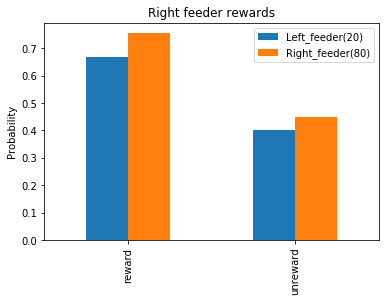

In [0]:
exp.run_prob('R reward')